In [1]:
%pip install scikit-learn -q
%pip install pandas -q
%pip install numpy -q
%pip install matplotlib -q
%pip install seaborn -q
%pip install keras -q
%pip install os -q

%pip install cvxopt -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


Note: you may need to restart the kernel to use updated packages.


In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random
import seaborn as sns
import os
import cvxEDA

In [141]:

MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/"

QUALITY_THRESHOLD = 128
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

In [142]:
dataset = pd.read_csv(DATA_PATH + "/merged_data.csv")

In [143]:
dataset.dtypes

w_eda                 float64
w_temp                float64
downsampled_labels    float64
ID                     object
Time                  float64
dtype: object

In [144]:
dataset

,w_eda,w_temp,downsampled_labels,ID,Time
0,1.138257,35.41,0.0,S2,0.00
1,1.125444,35.41,0.0,S2,0.25
2,1.011405,35.41,0.0,S2,0.50
3,1.033188,35.41,0.0,S2,0.75
4,0.935807,35.41,0.0,S2,1.00
...,...,...,...,...,...
347467,0.792287,31.81,0.0,S17,5918.75
347468,0.787170,31.81,0.0,S17,5919.00
347469,0.787170,31.81,0.0,S17,5919.25
347470,0.784611,31.81,0.0,S17,5919.50


In [145]:
import pandas as pd

# Function to create sequences DataFrame
def create_sequences_df(dataset, max_length=256):
    sequences = []
    temp_sequence = []
    eda_sequence = []
    label = None
    time_sequence = []
    current_id = None

    for index, row in dataset.iterrows():
        if current_id != row['ID']:
            # New ID encountered, append previous sequence to list
            if temp_sequence:
                sequences.append({
                    'ID': current_id,
                    'w_eda': eda_sequence,
                    'w_temp': temp_sequence,
                    'downsampled_label': label,
                    'Time': time_sequence
                })
            # Reset sequences for new ID
            temp_sequence = [row['w_temp']]
            eda_sequence = [row['w_eda']]
            label = row['downsampled_labels']
            time_sequence = [row['Time']]
            current_id = row['ID']
        else:
            # Append values to sequences
            temp_sequence.append(row['w_temp'])
            eda_sequence.append(row['w_eda'])
            time_sequence.append(row['Time'])

        # Check if sequence length exceeds max_length
        if len(temp_sequence) >= max_length:
            sequences.append({
                'ID': current_id,
                'w_eda': eda_sequence,
                'w_temp': temp_sequence,
                'downsampled_label': label,
                'Time': time_sequence
            })
            # Reset sequences for new ID
            temp_sequence = []
            eda_sequence = []
            label = None
            time_sequence = []
            current_id = None

    # Append last sequence if it's not empty
    if temp_sequence:
        sequences.append({
            'ID': current_id,
            'w_eda': eda_sequence,
            'w_temp': temp_sequence,
            'downsampled_label': label,
            'Time': time_sequence
        })

    # Convert list of dictionaries to DataFrame
    sequences_df = pd.DataFrame(sequences)
    return sequences_df

# Create sequences DataFrame
sequences_df = create_sequences_df(dataset)

# Check the resulting DataFrame
sequences_df

,ID,w_eda,w_temp,downsampled_label,Time
0,S2,"[1.138257, 1.125444, 1.011405, 1.033188, 0.935...","[35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35....",0.0,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2..."
1,S2,"[0.962616, 0.958772, 0.94724, 0.943396, 0.9369...","[35.57, 35.57, 35.57, 35.57, 35.55, 35.55, 35....",0.0,"[64.0, 64.25, 64.5, 64.75, 65.0, 65.25, 65.5, ..."
2,S2,"[1.011306, 1.008744, 1.007462, 1.006181, 1.006...","[35.57, 35.57, 35.57, 35.57, 35.57, 35.57, 35....",0.0,"[128.0, 128.25, 128.5, 128.75, 129.0, 129.25, ..."
3,S2,"[1.007462, 1.0049, 1.003618, 0.999774, 0.99977...","[35.81, 35.81, 35.81, 35.81, 35.79, 35.79, 35....",0.0,"[192.0, 192.25, 192.5, 192.75, 193.0, 193.25, ..."
4,S2,"[1.139439, 1.13047, 1.126626, 1.129189, 1.1240...","[35.79, 35.79, 35.79, 35.79, 35.81, 35.81, 35....",0.0,"[256.0, 256.25, 256.5, 256.75, 257.0, 257.25, ..."
...,...,...,...,...,...
1358,S17,"[0.862655, 0.865213, 0.858816, 0.847302, 0.830...","[32.27, 32.25, 32.25, 32.25, 32.25, 32.27, 32....",4.0,"[5632.0, 5632.25, 5632.5, 5632.75, 5633.0, 563..."
1359,S17,"[1.092947, 1.091668, 1.092947, 1.091668, 1.092...","[32.09, 32.07, 32.07, 32.07, 32.07, 32.09, 32....",0.0,"[5696.0, 5696.25, 5696.5, 5696.75, 5697.0, 569..."
1360,S17,"[1.012345, 1.005948, 1.004668, 1.00083, 0.9995...","[31.87, 31.87, 31.87, 31.87, 31.87, 31.87, 31....",0.0,"[5760.0, 5760.25, 5760.5, 5760.75, 5761.0, 576..."
1361,S17,"[0.981639, 0.976522, 0.97908, 0.97908, 0.98036...","[31.97, 31.93, 31.93, 31.93, 31.93, 31.93, 31....",0.0,"[5824.0, 5824.25, 5824.5, 5824.75, 5825.0, 582..."


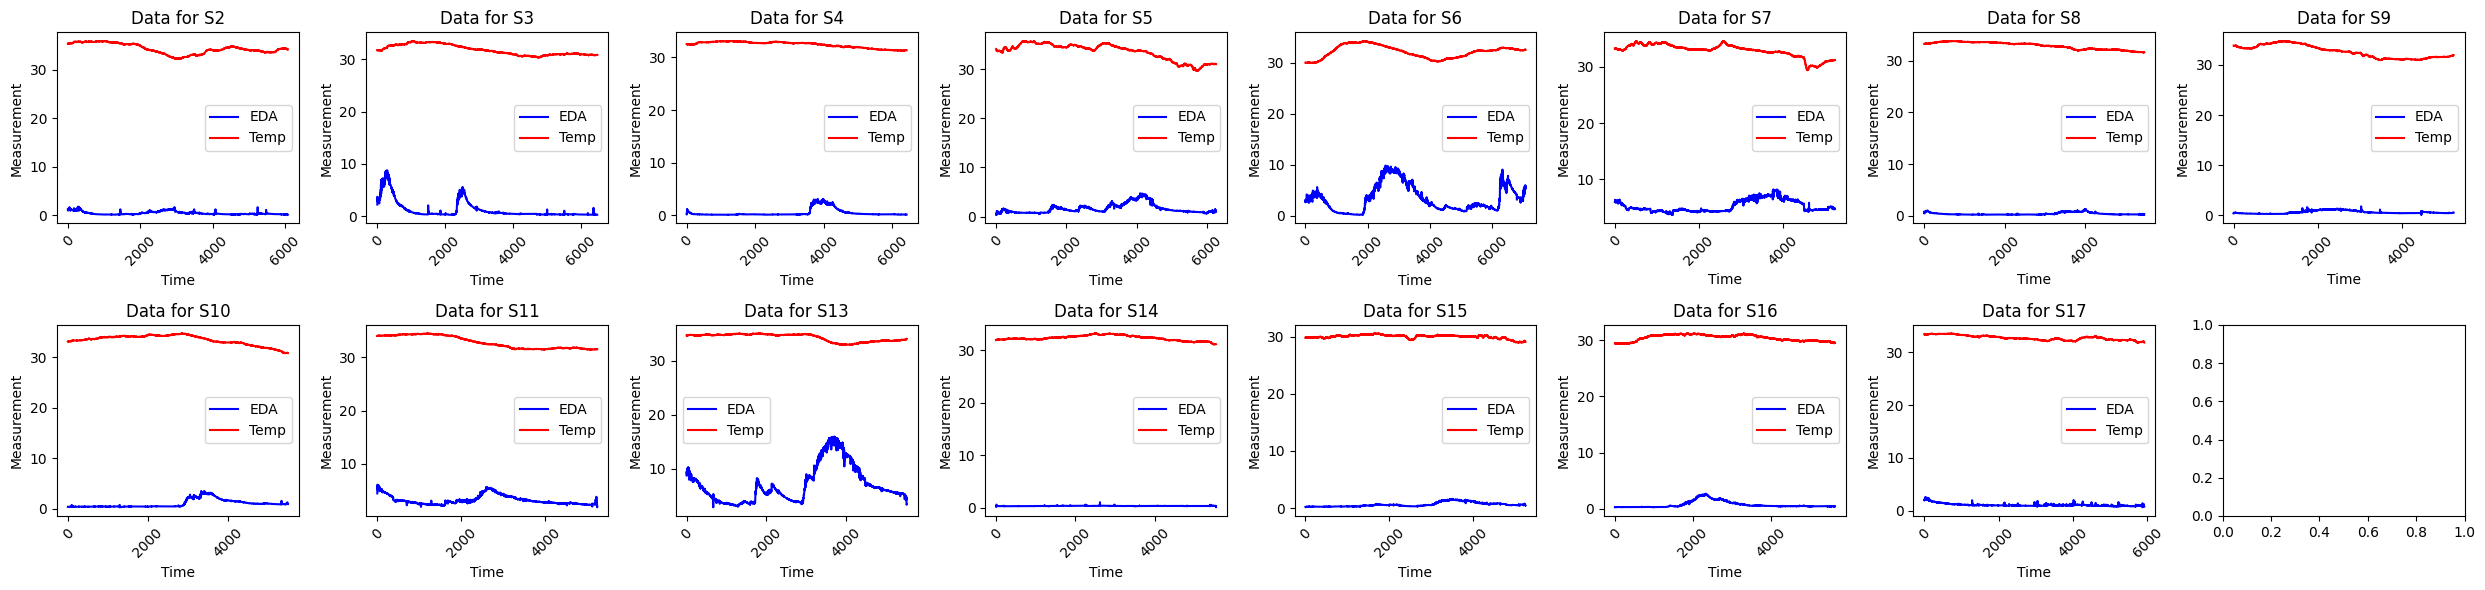

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 8, figsize=(25, 6))  # Increased figure size
axes = axes.flatten()

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Iterate through each unique id
for i, unique_id in enumerate(unique_ids):
    if i < len(unique_ids):
        # Filter data for each id
        subset_data = dataset[dataset['ID'] == unique_id]
        
        # Plotting
        sns.lineplot(x='Time', y='w_eda', data=subset_data, ax=axes[i], color='blue', label='EDA')
        sns.lineplot(x='Time', y='w_temp', data=subset_data, ax=axes[i], color='red', label='Temp')

        axes[i].set_title(f"Data for {unique_id}")
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Measurement')
        axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [8]:
# import matplotlib.pyplot as plt

# # Create subplots
# fig, axes = plt.subplots(16, 3, figsize=(60, 40))  # Increased figure size

# # Define colors for each acceleration component
# colors = ['red', 'green', 'blue']

# # Iterate through each unique id
# for i, unique_id in enumerate(unique_ids):
#     # Filter data for each id
#     subset_data = dataset[dataset['ID'] == unique_id]
    
#     # Iterate through X, Y, and Z accelerations
#     for j, accel_component in enumerate(['X', 'Y', 'Z']):
#         ax = axes[i, j]  # Select the appropriate subplot
        
#         # Plot acceleration component with different color
#         ax.plot(subset_data['Time'], subset_data[accel_component], label=f'{accel_component} Acceleration', color=colors[j])
#         ax.set_title(f"Data for {unique_id} - {accel_component} Acceleration")
#         ax.set_xlabel('Time')
#         ax.set_ylabel('Acceleration')
#         ax.legend()
#         ax.tick_params(axis='x', rotation=45)

# # Adjust layout
# plt.tight_layout()
# plt.show()


In [121]:
import cvxEDA.src.cvxEDA

def calculate_eda_levels(y):
    fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700}
    Fs = fs_dict['EDA']
    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA.src.cvxEDA.cvxEDA(yn, 1. / Fs)
    return [p, t]


In [ ]:
import matplotlib.pyplot as plt

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Iterate through each unique id
for unique_id in unique_ids:
    # Filter data for each id
    subset_data = dataset[dataset['ID'] == unique_id]
    
    # Calculate EDA levels
    tonic, phasic = calculate_eda_levels(subset_data['w_eda'].values)
    
    # Plotting
    plt.plot(tonic, label='Tonic')
    plt.plot(phasic, label='Phasic')
    plt.plot(subset_data['w_eda'].values, label='EDA')
    
    plt.xlabel('Time')
    plt.ylabel('EDA Levels')
    plt.title(f'Phasic and Tonic EDA for ID: {unique_id}')
    plt.legend()
    plt.show()


In [148]:
print("Before replacing labels")
unique_labels_before = sequences_df['downsampled_label'].unique()
print(unique_labels_before, "\n")
print("Number of unique labels before replacement:", len(unique_labels_before), "\n")


Before replacing labels
[0. 1. 2. 4. 3.] 

Number of unique labels before replacement: 5 



In [149]:

dataset.replace(
    {
        "downsampled_labels": {
            0: "transient",
            1: "baseline",
            2: "stress",
            3: "amusement",
            4: "meditation",
            5: "ignored",
            6: "ignored",
            7: "ignored",
        }
    },
    inplace=True,
)


In [150]:
from sklearn import preprocessing

print("After replacing labels")
unique_labels_after = sequences_df['downsampled_label'].unique()
print(unique_labels_after)
print("Number of unique labels after replacement:", len(unique_labels_after))

le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(sequences_df['downsampled_label'])
sequences_df['downsampled_label'] = le.transform(sequences_df['downsampled_label'])


After replacing labels
[0. 1. 2. 4. 3.]
Number of unique labels after replacement: 5


In [151]:
num_classes = len(sequences_df['downsampled_label'].unique())
print(num_classes)


5


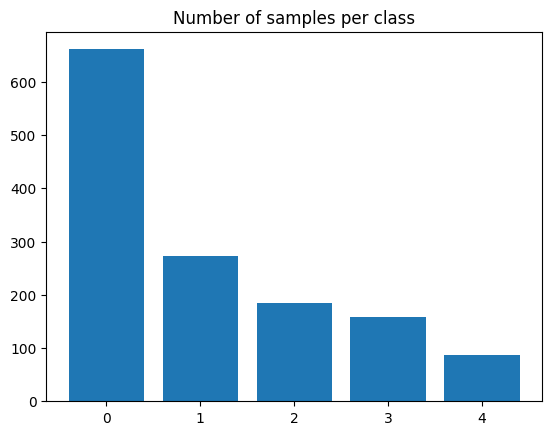

In [152]:
plt.bar(range(num_classes), sequences_df['downsampled_label'].value_counts())
plt.title("Number of samples per class")
plt.show()


****Scale and split data****

We perform a simple Min-Max scaling to bring the value-range between 0 and 1. We do not use Standard Scaling as the data does not follow a Gaussian distribution.

In [153]:
# Scale the 'w_eda' feature
scaler = preprocessing.MinMaxScaler()
series_list = [
    scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in sequences_df["w_eda"]
]

# Separate the labels
labels_list = [i for i in sequences_df['downsampled_label']]

print(len(series_list))
print(len(labels_list))


1363
1363


In [155]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding sequences to ensure uniform length
max_sequence_length = 512  # Choose the desired maximum sequence length
padded_series_list = pad_sequences(series_list, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Splitting data into training and testing sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    padded_series_list, labels_list, test_size=0.15, random_state=42, shuffle=True
)

# Convert to numpy arrays and reshape for compatibility with Keras
x_train = np.asarray(x_train).astype(np.float32).reshape(-1, max_sequence_length, 1)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

x_test = np.asarray(x_test).astype(np.float32).reshape(-1, max_sequence_length, 1)
y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

# Check lengths of train and test sets
print(
    f"Length of x_train : {len(x_train)}\nLength of x_test : {len(x_test)}\nLength of y_train : {len(y_train)}\nLength of y_test : {len(y_test)}"
)


Length of x_train : 1158
Length of x_test : 205
Length of y_train : 1158
Length of y_test : 205


In [156]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [157]:
vals_dict = {}
for i in sequences_df['downsampled_label']:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)



{0: 0.5150403521643434, 1: 0.7997065297138665, 2: 0.8840792369772561, 4: 0.8650036683785767, 3: 0.9361702127659575}


In [158]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [159]:
def create_model():
    input_layer = keras.Input(shape=(512, 1))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=1024,
        kernel_size=7,
        strides=2,
        activation="relu",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)

    # Add Flatten layer after the last convolutional layer
    x = layers.Flatten()(x)
    print("Shape after Flatten:", x.shape)
    
    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        2048, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        1024, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(
        128, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    output_layer = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs=input_layer, outputs=output_layer)


In [160]:
conv_model = create_model()
conv_model.summary()


Shape after Flatten: (None, 8192)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 512, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 256, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 256, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 128, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 64, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 32, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 32, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 16, 512)        │       918,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 16, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 8, 1024)        │     3,671,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 8, 1024)        │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 8, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │       131,20

 Total params: 48,987,845 (186.87 MB)

 Trainable params: 48,983,813 (186.86 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [177]:
epochs = 60

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_top_k_categorical_accuracy",
        factor=0.2,
        patience=2,
        min_lr=0.000001,
    ),
]

optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy()


In [178]:

conv_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        keras.metrics.TopKCategoricalAccuracy(k=3),
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

conv_model_history = conv_model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_dataset,
    class_weight=weight_dict,
)


Epoch 1/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - auc_7: 0.6685 - loss: 4.0851 - precision_7: 0.4169 - recall_7: 0.0969 - top_k_categorical_accuracy: 0.7618 - val_auc_7: 0.7288 - val_loss: 3.7361 - val_precision_7: 0.5171 - val_recall_7: 0.5171 - val_top_k_categorical_accuracy: 0.8049 - learning_rate: 0.0010
Epoch 2/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - auc_7: 0.7153 - loss: 1.7268 - precision_7: 0.5100 - recall_7: 0.0551 - top_k_categorical_accuracy: 0.8373 - val_auc_7: 0.4969 - val_loss: 5.9279 - val_precision_7: 0.1891 - val_recall_7: 0.1854 - val_top_k_categorical_accuracy: 0.8244 - learning_rate: 0.0010
Epoch 3/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - auc_7: 0.7663 - loss: 1.3028 - precision_7: 0.4298 - recall_7: 0.0596 - top_k_categorical_accuracy: 0.8886 - val_auc_7: 0.4918 - val_loss: 7.3752 - val_precision_7: 0.1854 - val_recall_7: 0.1854 - val_top_k_categorical_accuracy: 0.8244 - learning_rate: 0.0010
Epoch 4/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - auc_7: 0.771

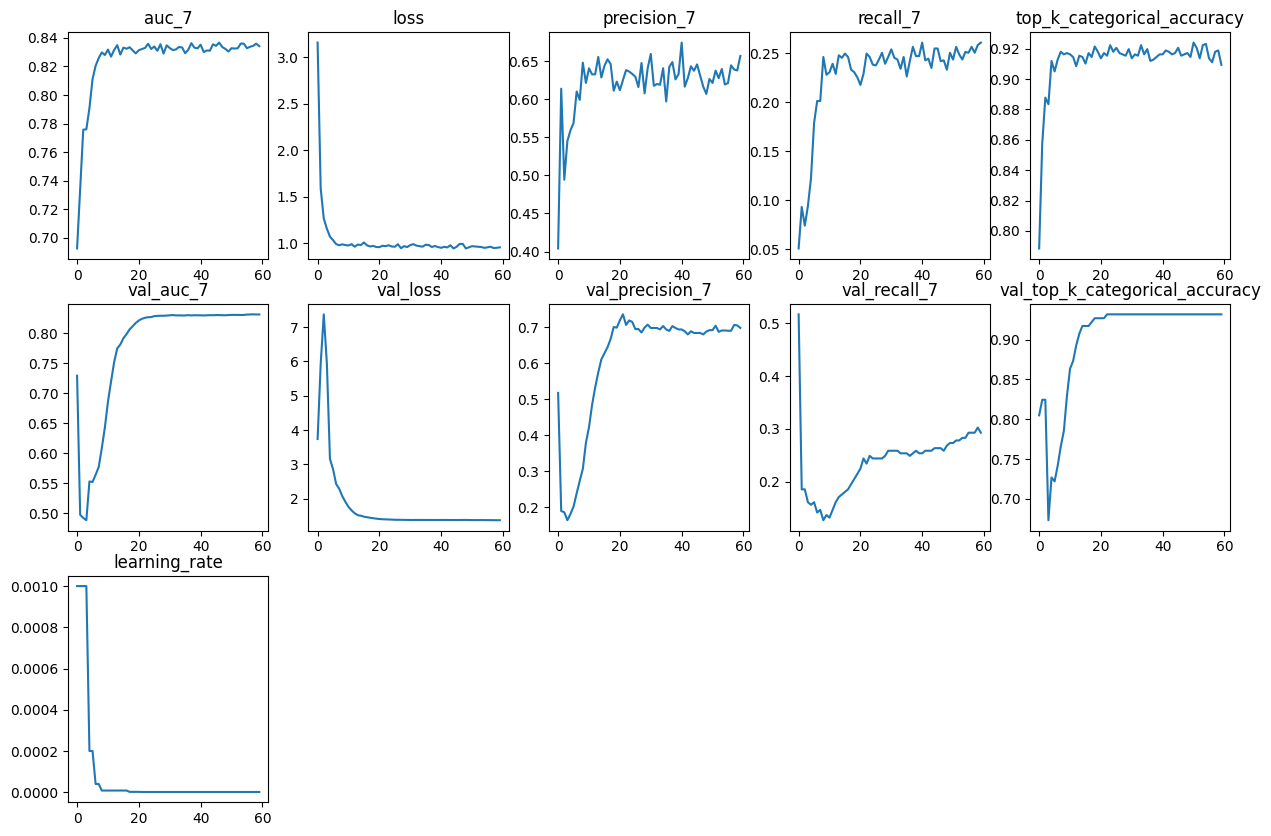

In [179]:
plot_history_metrics(conv_model_history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - auc_7: 0.8273 - loss: 1.3187 - precision_7: 0.6531 - recall_7: 0.2853 - top_k_categorical_accuracy: 0.9185 
Loss : 1.3697073459625244
Top 3 Categorical Accuracy : 0.8308863639831543
Area under the Curve (ROC) : 0.6976743936538696
Precision : 0.2926829159259796
Recall : 0.9317073225975037


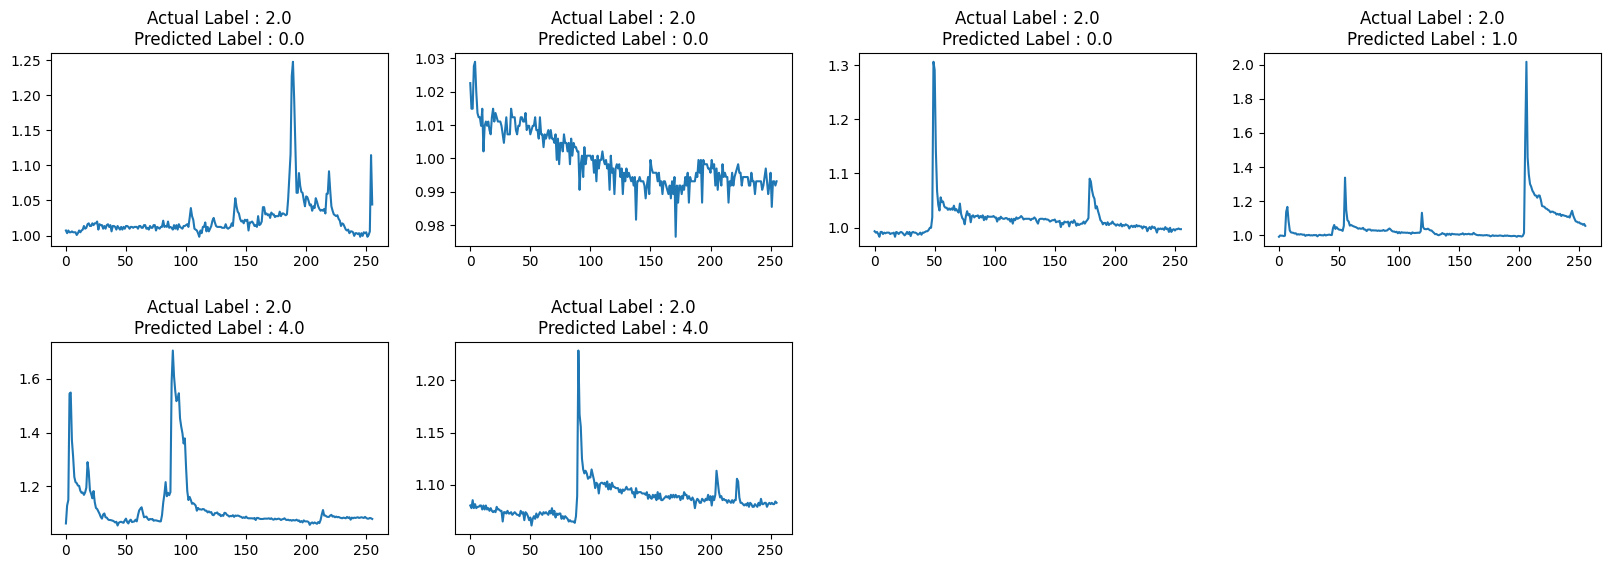

In [181]:
loss, accuracy, auc, precision, recall = conv_model.evaluate(test_dataset)
print(f"Loss : {loss}")
print(f"Top 3 Categorical Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")


def view_evaluated_eeg_plots(model):
    start_index = random.randint(10, len(sequences_df))
    end_index = start_index + 11
    data = sequences_df.loc[start_index:end_index, 'w_eda']
    data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
    data_array = [np.asarray(data_array).astype(np.float32).reshape(-1, 512, 1)]
    original_labels = sequences_df.loc[start_index:end_index, 'downsampled_label']
    predicted_labels = np.argmax(model.predict(data_array, verbose=0), axis=1)
    original_labels = [
        le.inverse_transform(np.array(label).reshape(-1))[0]
        for label in original_labels
    ]
    predicted_labels = [
        le.inverse_transform(np.array(label).reshape(-1))[0]
        for label in predicted_labels
    ]
    total_plots = 12
    cols = total_plots // 3
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1
    pos = range(1, total_plots + 1)
    fig = plt.figure(figsize=(20, 10))
    for i, (plot_data, og_label, pred_label) in enumerate(
        zip(data, original_labels, predicted_labels)
    ):
        plt.subplot(rows, cols, pos[i])
        plt.plot(plot_data)
        plt.title(f"Actual Label : {og_label}\nPredicted Label : {pred_label}")
        fig.subplots_adjust(hspace=0.5)
    plt.show()


view_evaluated_eeg_plots(conv_model)
